## General Imports

In [1]:
from numpy import concatenate, bitwise_xor, zeros, packbits, ceil, asarray, floor, reshape
from numpy import dot, conj, prod, sqrt, exp, pi, diag, angle, array, argwhere, real, pad, fromfile, unpackbits
from numpy.linalg import qr, multi_dot, svd
from numpy.random import uniform, normal, randint, choice
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
start = time.process_time()

## Essential System Parameters

In [2]:
pls_profiles = {'bandwidth': 960e3, 
                'bin_spacing': 15e3, 
                'num_ant': 2, 
                'bit_codebook': 4}
SNR_dB = 60 

##  Import two helper classes and define some helper variables
PLS PARAMETERS: which defines essential Physical Layer Security parameters, codebook and channel models\
NODE: where all the wireless signal processing happens

In [3]:
from PLSParameters import PLSParameters
from Node import Node
pls_params = PLSParameters(pls_profiles)
codebook = pls_params.codebook_gen()
N = Node(pls_params)  # Wireless network node - could be Alice or Bob

DC_index = int(pls_params.NFFT / 2)
neg_data_bins = list(range(DC_index - int(pls_params.num_used_bins / 2), DC_index))
pos_data_bins = list(range(DC_index + 1, DC_index + int(pls_params.num_used_bins / 2) + 1))
used_data_bins = array(neg_data_bins + pos_data_bins) 
plt.style.use('seaborn-whitegrid')

## Main Code Run
This is the image we wish to transmit privately. 

Text(0.5, 1.0, 'Image which we wish to transmit privately')

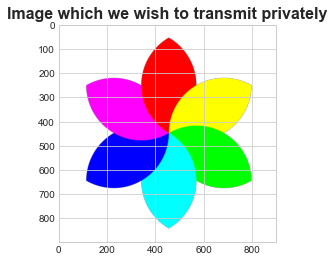

In [4]:
# set up data to be transmitted - 'text' or 'image'
bits_to_tx = N.secret_key_gen('image')
img = mpimg.imread('flower.png')
imgplot = plt.imshow(img)
plt.title('Image which we wish to transmit privately', fontsize=16, fontweight="bold")


## Calculate the system parameters that we need in order to send this image

In [5]:
print('Number of bits in the image:', len(bits_to_tx))
num_symbols = int(ceil(len(bits_to_tx)/(pls_params.num_subbands * pls_params.bit_codebook)))
print('-----System Parameters-----')
print(f'Bandwidth: {pls_params.bandwidth}')
print(f'FFT: {pls_params.NFFT}')
print(f'Used freq bins: {pls_params.num_used_bins}')
print(f'Sub-band size: {pls_params.subband_size}')
# Groups of 2 frequency bins form a sub-band (This is because the precoders are 2x2 matrices and are split across 2 bins
print(f'Number of sub-bands: {pls_params.num_subbands}')
print(f'Total number of OFDM symbols required: {num_symbols}')

Number of bits in the image: 216008
-----System Parameters-----
Bandwidth: 960000.0
FFT: 64
Used freq bins: 62
Sub-band size: 2
Number of sub-bands: 31
Total number of OFDM symbols required: 1742


## Alice to Bob Initiation Step
1. Alice sends reference signals rotated by a random unitary operator
2. The random unitary effectively creates uniformly distributed signaling

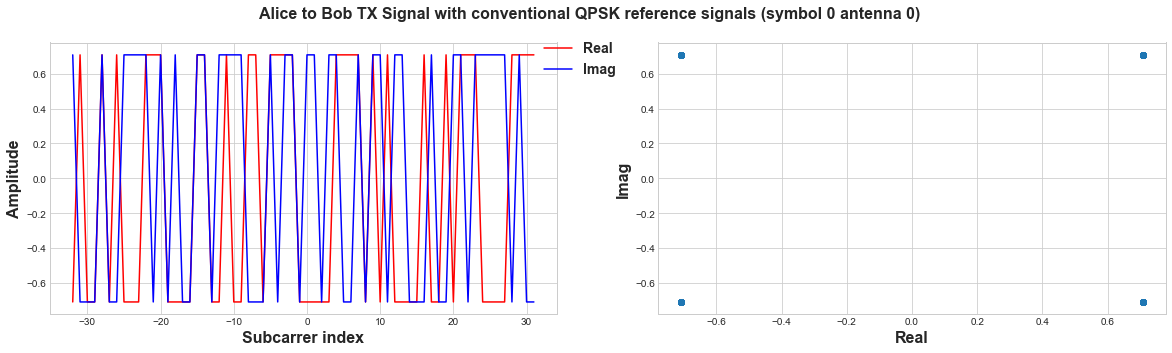

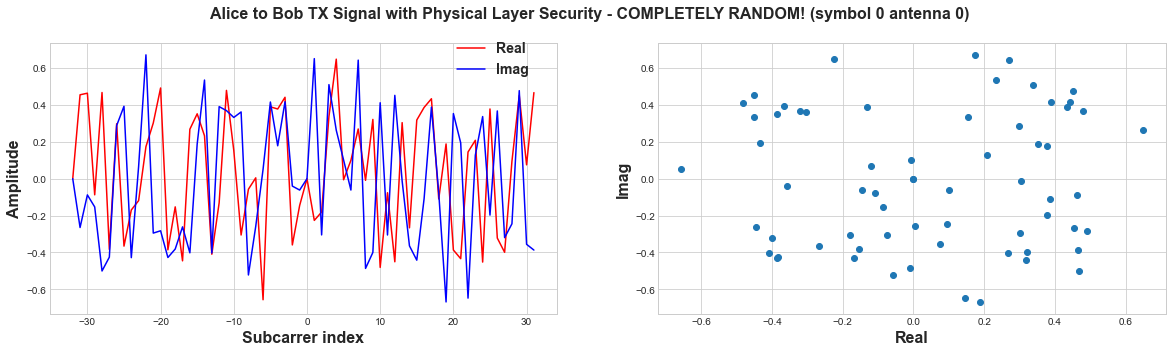

In [6]:
bits_subbandB = zeros(num_symbols, dtype=object)
bits_in_symb = zeros(num_symbols, dtype=object)
HAB, HBA = zeros(num_symbols, dtype=object), zeros(num_symbols, dtype=object)
rx_sigB0 = zeros(num_symbols, dtype=object)
for symb in range(num_symbols):
    
    bits_start = symb*pls_params.num_subbands*pls_params.bit_codebook
    bits_end = bits_start + (pls_params.num_subbands*pls_params.bit_codebook)
    bits_in_symb[symb] = bits_to_tx[bits_start: bits_end]
    bits_subbandB[symb] = N.map_key2subband(bits_in_symb[symb])
    HAB[symb], HBA[symb] = pls_params.channel_gen()
    
    ## 1. Alice to Bob
    GA = N.unitary_gen()
    rx_sigB0[symb] = N.receive('Bob', SNR_dB, HAB[symb], GA)
    
    if symb == 0:
        gA = list()    
        for sb in range(pls_params.num_subbands):
            gA0 = GA[sb] 
            gA.extend(gA0[0, :])
        gA = array(gA)

        xax = array(range(-int(pls_params.NFFT/2), int(pls_params.NFFT/2)))

        gA_used = zeros(pls_params.NFFT, dtype=complex)
        gA_used[used_data_bins] = gA
        
        qpsk_rand = exp(1j * (pi / 4) * (choice(array([1, 3, 5, 7]), pls_params.NFFT)))

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        ax[0].plot(xax, qpsk_rand.real, color = 'red', label='Real')
        ax[0].set_xlabel('Subcarrer index', fontsize=16, fontweight="bold") 
        ax[0].set_ylabel('Amplitude', fontsize=16, fontweight="bold") 
        ax[0].plot(xax, qpsk_rand.imag, color = 'blue', label='Imag')
        ax[0].legend(bbox_to_anchor=(0.95, 1.05), prop={"size": 14, "weight": "bold"})
        ax[1].scatter(qpsk_rand.real, qpsk_rand.imag)
        ax[1].set_xlabel('Real', fontsize=16, fontweight="bold") 
        ax[1].set_ylabel('Imag', fontsize=16, fontweight="bold") 
        fig.suptitle('Alice to Bob TX Signal with conventional QPSK reference signals (symbol 0 antenna 0)', fontsize=16, fontweight="bold")

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        ax[0].plot(xax, gA_used.real*qpsk_rand.real, color = 'red', label='Real')
        ax[0].set_xlabel('Subcarrer index', fontsize=16, fontweight="bold") 
        ax[0].set_ylabel('Amplitude', fontsize=16, fontweight="bold") 
        ax[0].plot(xax, gA_used.imag*qpsk_rand.imag, color = 'blue', label='Imag')
        ax[0].legend(bbox_to_anchor=(0.97, 1.05), prop={"size": 14, "weight": "bold"})
        ax[1].scatter(gA_used.real*qpsk_rand.real, gA_used.imag*qpsk_rand.imag)
        ax[1].set_xlabel('Real', fontsize=16, fontweight="bold") 
        ax[1].set_ylabel('Imag', fontsize=16, fontweight="bold") 
        fig.suptitle('Alice to Bob TX Signal with Physical Layer Security - COMPLETELY RANDOM! (symbol 0 antenna 0)', fontsize=16, fontweight="bold")
        plt.show()


## Bob to Alice Transmission of Secret Information
1. This is where private info transfer begins 
2. Bob maps info bits to precoders in a codebook
3. Bob applies precoders in each sub-carrier
4. Alice receives this, performs SVD and decodes the precoder
5. Alice maps precoder to bits to recover image

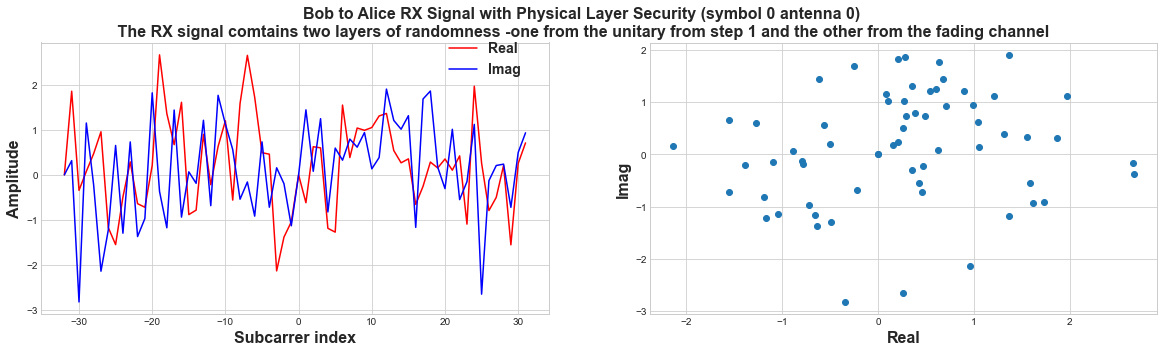

In [7]:
VA = zeros(num_symbols, dtype=object)
for symb in range(num_symbols):
    ## 1. At Bob - private info transmission starts here
    UB0 = N.sv_decomp(rx_sigB0[symb])[0]

    FB = N.precoder_select(bits_subbandB[symb], codebook)
    
    ## 2. Bob to Alice
    rx_sigA = N.receive('Alice', SNR_dB, HBA[symb], UB0, FB)

    ## 2. At Alice
    UA, _, VA[symb] = N.sv_decomp(rx_sigA)
    
    
    if symb == 0:
        rxA = list()    
        for sb in range(pls_params.num_subbands):
            rA0 = rx_sigA[sb] 
            rxA.extend(rA0[0, :])
        rxA = array(rxA)

        xax = array(range(-int(pls_params.NFFT/2), int(pls_params.NFFT/2)))

        rxA_used = zeros(pls_params.NFFT, dtype=complex)
        rxA_used[used_data_bins] = rxA
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        ax[0].plot(xax, rxA_used.real, color = 'red', label='Real')
        ax[0].set_xlabel('Subcarrer index', fontsize=16, fontweight="bold") 
        ax[0].set_ylabel('Amplitude', fontsize=16, fontweight="bold") 
        ax[0].plot(xax, rxA_used.imag, color = 'blue', label='Imag')
        ax[0].legend(bbox_to_anchor=(0.97, 1.05), prop={"size": 14, "weight": "bold"})
        ax[1].scatter(rxA_used.real, rxA_used.imag)
        ax[1].set_xlabel('Real', fontsize=16, fontweight="bold") 
        ax[1].set_ylabel('Imag', fontsize=16, fontweight="bold") 
        fig.suptitle('Bob to Alice RX Signal with Physical Layer Security (symbol 0 antenna 0)\n The RX signal comtains two layers of randomness -one from the unitary from step 1 and the other from the fading channel', fontsize=16, fontweight="bold")
        plt.show()

        

## Private information recovery by Alice (In our research we use AI here)
1. Alice maps precoders to bits to recover image

Text(0.5, 1.0, 'Recovered private image from received random signal')

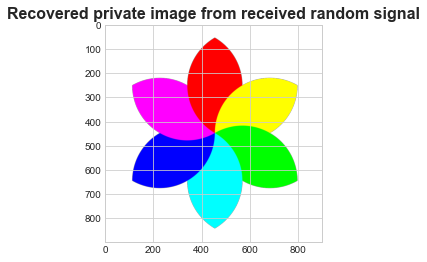

In [8]:
bits_recovered = zeros(len(bits_to_tx), dtype=int)
for symb in range(num_symbols):  
    bits_sb_estimateB = N.PMI_estimate(VA[symb], codebook)[1]
    bits_start = symb*pls_params.num_subbands*pls_params.bit_codebook
    bits_end = bits_start + (pls_params.num_subbands*pls_params.bit_codebook)
    
    actual_keyB = concatenate(bits_subbandB[symb])
    observed_keyB = concatenate(bits_sb_estimateB)
    num_errorsA = bitwise_xor(actual_keyB, observed_keyB).sum()
    # print(num_errorsA)

    bits_recovered[bits_start: bits_end] = observed_keyB[0: len(bits_in_symb[symb])]

out_bits = bits_recovered
out_bytes = packbits(out_bits)
out_name = f'flower_out_{SNR_dB}dB.png'
out_bytes.tofile(out_name)
img = mpimg.imread(out_name)
imgplot = plt.imshow(img)
plt.title('Recovered private image from received random signal', fontsize=16, fontweight="bold")


In [9]:
print(f'Time to run: {time.process_time() - start} seconds')

Time to run: 23.791251 seconds
